# Compare synthetic forecasts from model fit to real GCM forecasts

To do:
- Check what your forecasts look like relative to real forecasts
- Try fitting to hindcast winter NAO index
- Trend in one signal and trend in both signals

In [1]:
%cd /g/data/xv83/users/ds0092/active_projects/Squire_2022_correlation/notebooks/exploratory

/g/data4/xv83/users/ds0092/active_projects/Squire_2022_correlation/notebooks/exploratory


In [2]:
import cftime

import socket

import itertools

import numpy as np

import xarray as xr

import matplotlib
import matplotlib.pyplot as plt

import dask

dask.config.set(**{"array.slicing.split_large_chunks": False})

from src import utils, plot, stats, ar_model

In [3]:
DATA_DIR = "../../data/processed/"

In [4]:
%load_ext autoreload
%autoreload 2
%load_ext lab_black

In [18]:
matplotlib.rcParams["figure.figsize"] = (14, 6)
matplotlib.rcParams["font.size"] = 12
matplotlib.rcParams["axes.grid"] = True

## Cluster

In [6]:
from dask.distributed import Client

walltime = "02:00:00"
cores = 16
memory = "47GB"

if "ood" in socket.gethostname():
    from dask_jobqueue import SLURMCluster as Cluster

    kwargs = {}
else:
    from dask_jobqueue import PBSCluster as Cluster

    kwargs = dict(
        job_extra=[
            "-l ncpus=" + str(cores),
            "-l mem=" + str(memory),
            "-P xv83",
            "-l jobfs=100GB",
            "-l storage=gdata/xv83+gdata/oi10+gdata/ua8",
        ],
        local_directory="$PBS_JOBFS",
        header_skip=["select"],
    )

cluster = Cluster(walltime=str(walltime), cores=cores, memory=str(memory), **kwargs)
cluster.scale(jobs=4)
Client(cluster)

/g/data/xv83/users/ds0092/software/miniconda3/envs/squire_2022_correlation/lib/python3.10/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


<Client: 'tcp://10.0.128.137:33515' processes=0 threads=0, memory=0 B>

## Load some data to fit and compare to

#### Reanalysis data

In [7]:
tos = xr.open_zarr(f"{DATA_DIR}/tos_HadISST.zarr", use_cftime=True)
AMV = utils.calculate_period_AMV_index(tos["sst"], [12, 1, 2, 3]).to_dataset(name="AMV")
AMV = utils.round_to_start_of_month(AMV, dim="time")

psl = xr.open_zarr(f"{DATA_DIR}/psl_HadSLP2r.zarr", use_cftime=True)
NAO = utils.calculate_period_NAO_index(psl["slp"], [12, 1, 2, 3]).to_dataset(name="NAO")

reanalysis = xr.merge((AMV.compute(), NAO.compute()), join="inner")
reanalysis = reanalysis.assign_coords({"time": reanalysis.time.dt.year})

reanalysis_mean = utils.get_observation_rolling_mean(reanalysis, rolling_mean=[1, 4, 8])

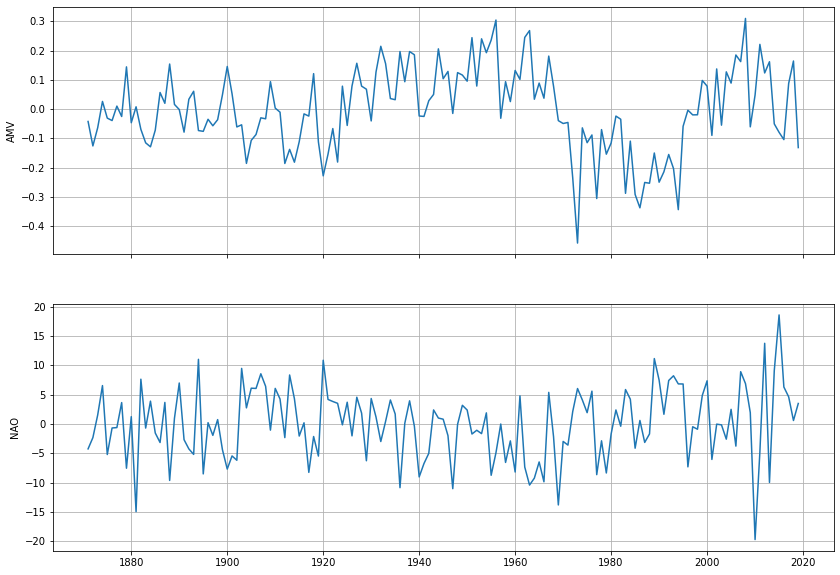

In [8]:
fig = plt.figure(figsize=(14, 10))
axs = fig.subplots(len(reanalysis), 1, sharex=True)

for idx, var in enumerate(reanalysis):
    ax = axs[idx]
    ax.plot(reanalysis.time, reanalysis[var])
    ax.set_ylabel(var)

#### Multi-model CMIP6 historical data

In [9]:
models = [
    "CanESM5",
    "CMCC-CM2-SR5",
    "EC-Earth3",
    "HadGEM3-GC31-MM",
    "IPSL-CM6A-LR",
    "MIROC6",
    "MPI-ESM1-2-HR",
    "NorCPM1",
]

historical = []
prev_member = 0
for model in models:
    tos = xr.open_zarr(f"{DATA_DIR}/tos_Omon_{model}_historical.zarr", use_cftime=True)
    AMV = utils.calculate_period_AMV_index(tos["tos"], [12, 1, 2, 3]).to_dataset(
        name="AMV"
    )

    psl = (
        xr.open_zarr(f"{DATA_DIR}/psl_Amon_{model}_historical.zarr", use_cftime=True)
        / 100
    )
    NAO = utils.calculate_period_NAO_index(psl["psl"], [12, 1, 2, 3]).to_dataset(
        name="NAO"
    )

    ds = xr.merge((AMV.compute(), NAO.compute()))
    ds = ds.assign_coords(
        {"member": np.array(range(1, ds.sizes["member"] + 1)) + prev_member}
    )
    ds = ds.assign_coords({"model": ("member", ds.sizes["member"] * [model])})
    ds = ds.assign_coords({"time": ds.time.dt.year})

    ds = utils.detrend(ds)

    prev_member = ds.member.values[-1]

    historical.append(ds)

historical = xr.concat(historical, dim="member")

historical_mean = utils.get_observation_rolling_mean(historical, rolling_mean=[1, 4, 8])

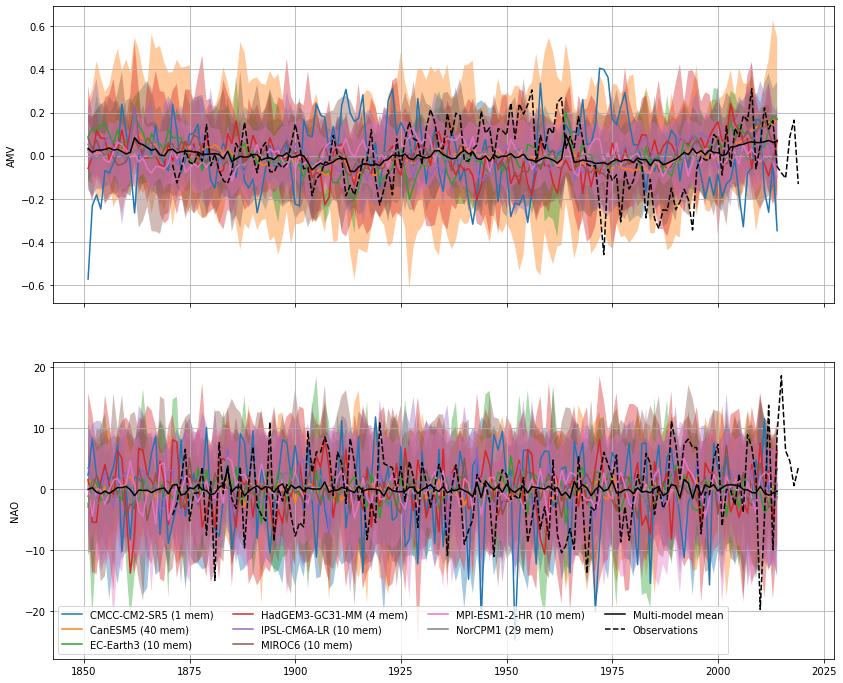

In [10]:
fig = plt.figure(figsize=(14, 12))
axs = fig.subplots(len(historical), 1, sharex=True)
q = (0.05, 0.95)

for idx, var in enumerate(historical):
    ax = axs[idx]
    for m in np.unique(historical.model):
        model = historical[var].where(historical.model == m, drop=True)
        n_members = model.sizes["member"]
        if n_members > 1:
            ax.fill_between(
                model.time,
                model.quantile(q[0], dim="member"),
                model.quantile(q[1], dim="member"),
                alpha=0.4,
            )
        label = f"{m} ({n_members} mem)"
        ax.plot(model.time, model.mean("member"), label=label)
    ax.plot(
        historical.time,
        historical[var].mean("member"),
        color="k",
        label="Multi-model mean",
    )
    ax.plot(
        reanalysis[var].time,
        reanalysis[var],
        color="k",
        linestyle="--",
        label="Observations",
    )
    ax.set_ylabel(var)
_ = axs[1].legend(ncol=4, loc="lower left")

#### Multi-model CMIP6 dcpp data

In [11]:
models = [
    "CanESM5",
    "CESM1-1-CAM5-CMIP5",
    "CMCC-CM2-SR5",
    "EC-Earth3",
    "HadGEM3-GC31-MM",
    "IPSL-CM6A-LR",
    "MIROC6",
    "MPI-ESM1-2-HR",
    "NorCPM1",
]

n_init = 57

hindcast = []
prev_member = 0
for model in models:
    tos = xr.open_zarr(f"{DATA_DIR}/tos_Omon_{model}_dcpp.zarr", use_cftime=True)
    AMV = utils.calculate_period_AMV_index(tos["tos"], [12, 1, 2, 3]).to_dataset(
        name="AMV"
    )
    AMV = AMV.assign_coords({"init": range(1960, 1960 + AMV.sizes["init"])})

    psl = xr.open_zarr(f"{DATA_DIR}/psl_Amon_{model}_dcpp.zarr", use_cftime=True) / 100
    NAO = utils.calculate_period_NAO_index(psl["psl"], [12, 1, 2, 3]).to_dataset(
        name="NAO"
    )
    NAO = NAO.assign_coords({"init": range(1960, 1960 + AMV.sizes["init"])})

    ds = xr.merge((AMV.compute(), NAO.compute()))
    ds = ds.sel(lead=slice(14, 120)).assign_coords({"lead": range(1, 10)})
    ds = ds.assign_coords(
        {"member": np.array(range(1, ds.sizes["member"] + 1)) + prev_member}
    )
    ds = ds.assign_coords({"model": ("member", ds.sizes["member"] * [model])})
    ds = utils.round_to_start_of_month(ds, "time")

    prev_member = ds.member.values[-1]

    hindcast.append(ds)

hindcast = xr.concat(
    hindcast, dim="member", coords="minimal", compat="override", join="inner"
)
hindcast = hindcast.assign_coords({"time": hindcast.time.dt.year})

hindcast_mean = utils.get_hindcast_mean(
    hindcast, mean_lead_range=[(0, 1), (0, 4), (0, 8)]
)

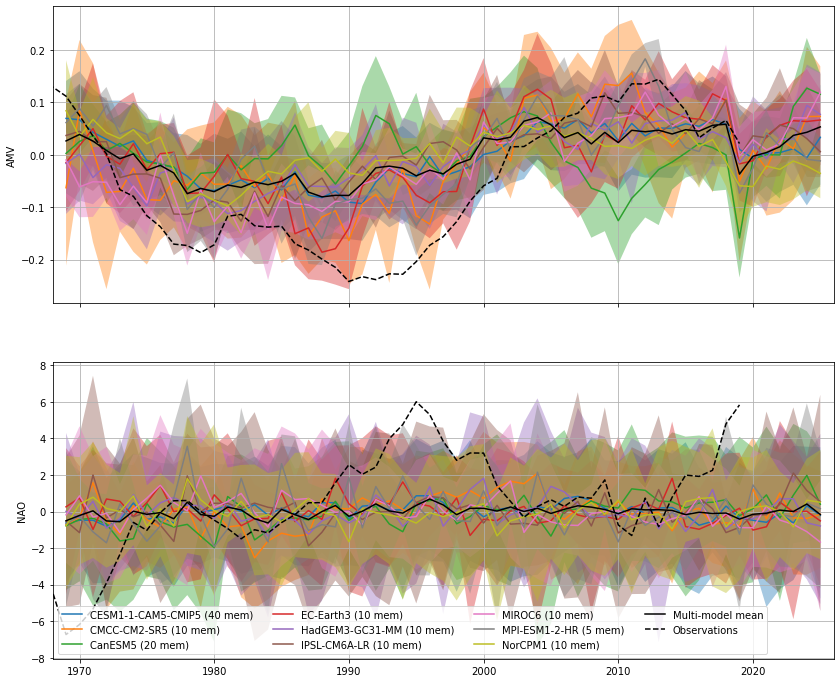

In [12]:
fig = plt.figure(figsize=(14, 12))
axs = fig.subplots(len(hindcast_mean), 1, sharex=True)
q = (0.05, 0.95)
rolling_mean = 8

for idx, var in enumerate(hindcast_mean):
    ax = axs[idx]
    for m in np.unique(hindcast_mean.model):
        model = (
            hindcast_mean[var]
            .sel(rolling_mean=rolling_mean)
            .where(hindcast_mean.model == m, drop=True)
        ).dropna("time")
        n_members = model.sizes["member"]
        if n_members > 1:
            ax.fill_between(
                model.time,
                model.quantile(q[0], dim="member"),
                model.quantile(q[1], dim="member"),
                alpha=0.4,
            )
        label = f"{m} ({n_members} mem)"
        ax.plot(model.time, model.mean("member"), label=label)
    ax.plot(
        hindcast_mean.time,
        hindcast_mean[var].sel(rolling_mean=rolling_mean).mean("member"),
        color="k",
        label="Multi-model mean",
    )
    reanalysis_plot = reanalysis_mean[var].sel(rolling_mean=rolling_mean)
    ax.plot(
        reanalysis_plot.time,
        reanalysis_plot,
        color="k",
        linestyle="--",
        label="Observations",
    )
    ax.set_xlim(model.time.min() - 1, model.time.max() + 1)
    ax.set_ylabel(var)
_ = axs[1].legend(ncol=4, loc="lower left")

In [13]:
cluster.scale(jobs=0)

## Fit a VAR model and generate some samples to compare to real hindcasts

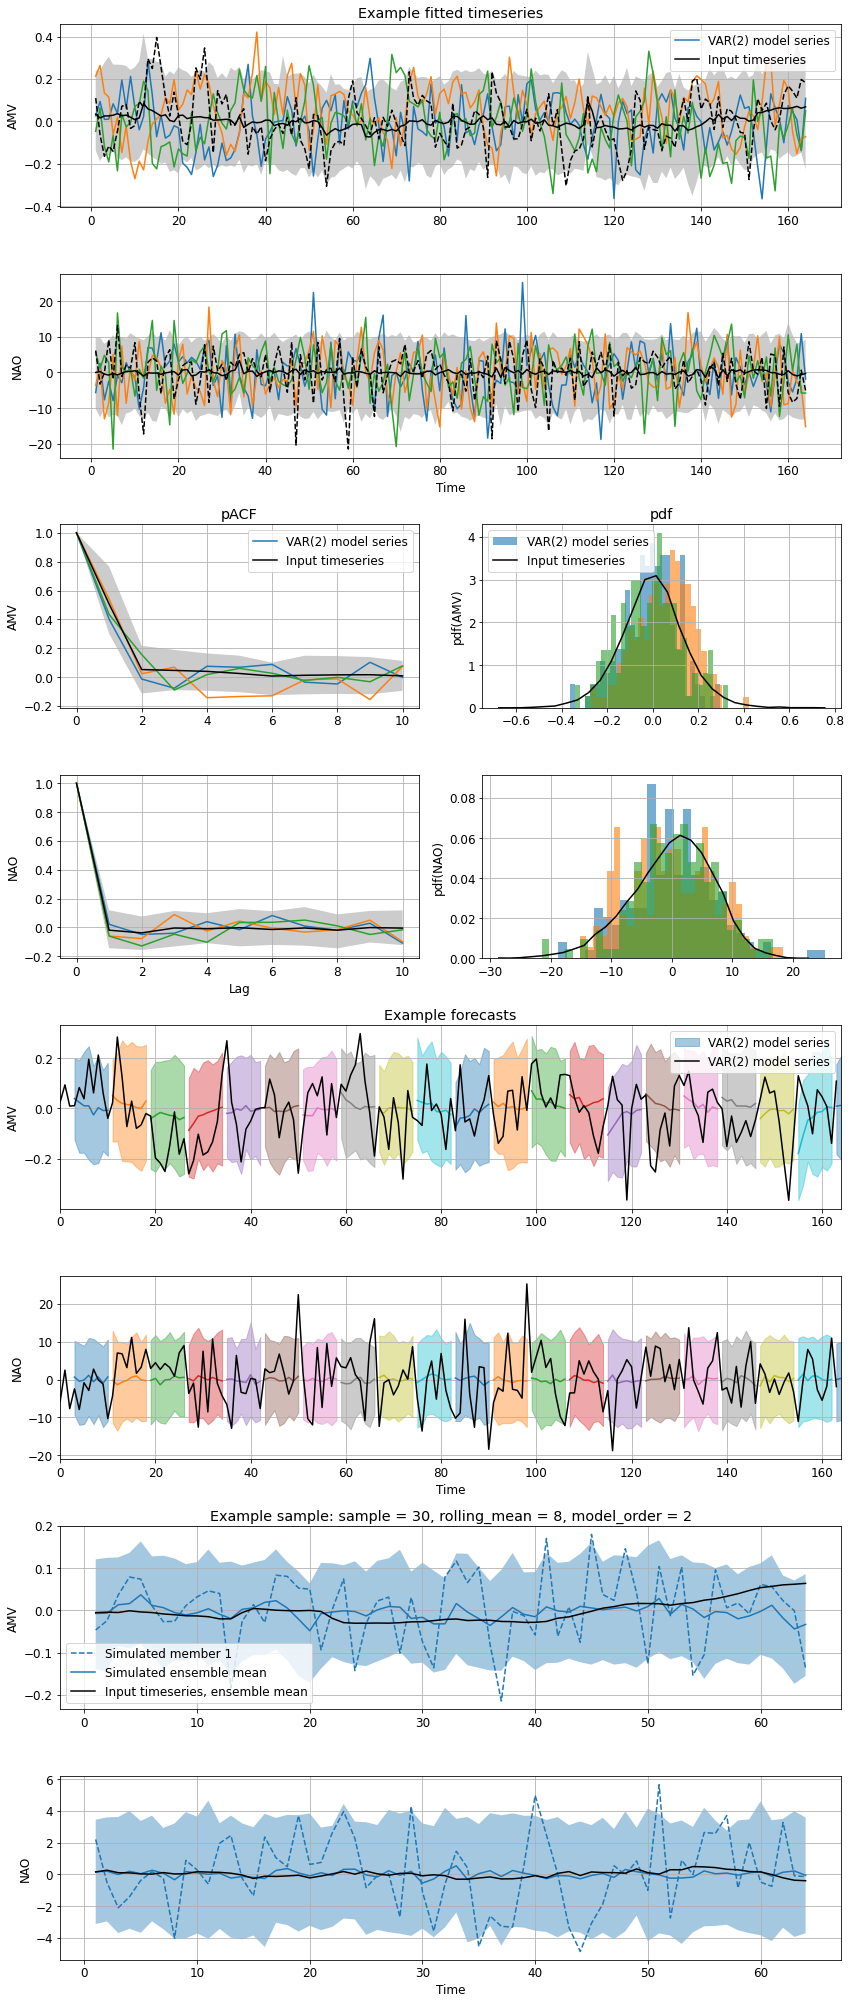

In [45]:
input_data = historical

synthetic = ar_model.generate_samples_like(
    input_data,
    n_lags=2,
    n_times=hindcast_mean.sizes["time"],
    n_samples=100,
    n_members=hindcast_mean.sizes["member"],
    rolling_means=[1, 4, 8],
)

## Compare the synthetic data to the real hindcasts

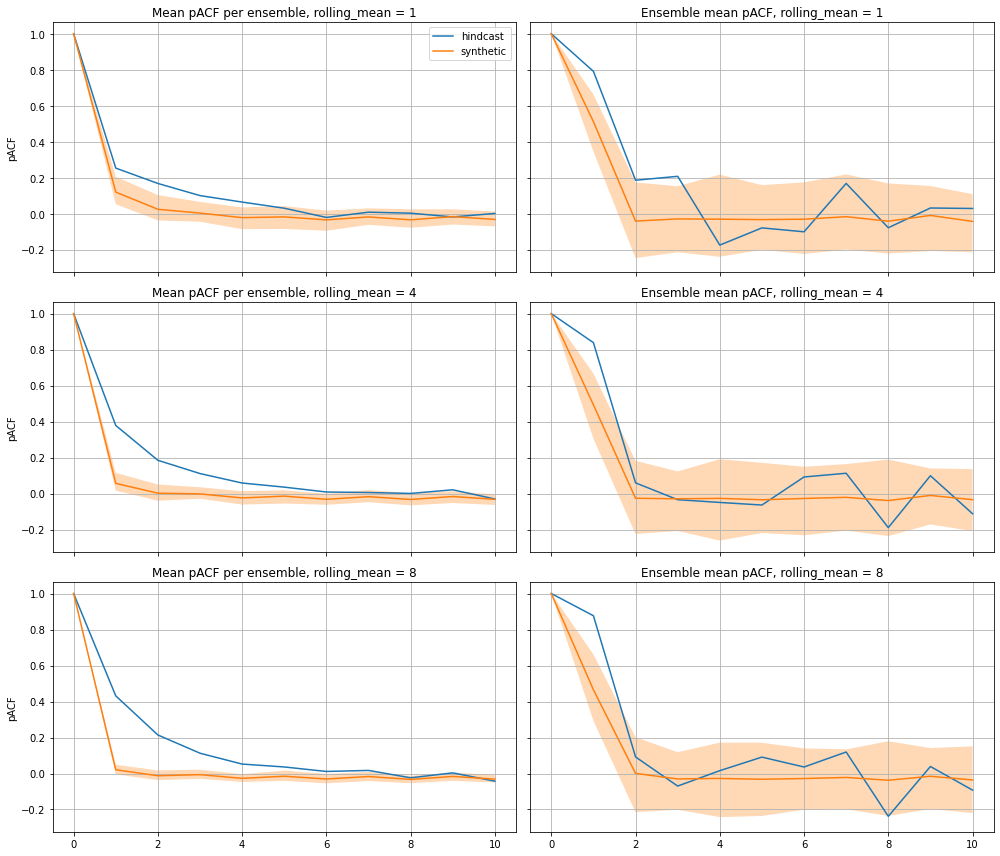

In [15]:
plot.acf(
    hindcast_mean["AMV"],
    synthetic["AMV"],
    headings=["hindcast", "synthetic"],
    partial=True,
    nlags=10,
)

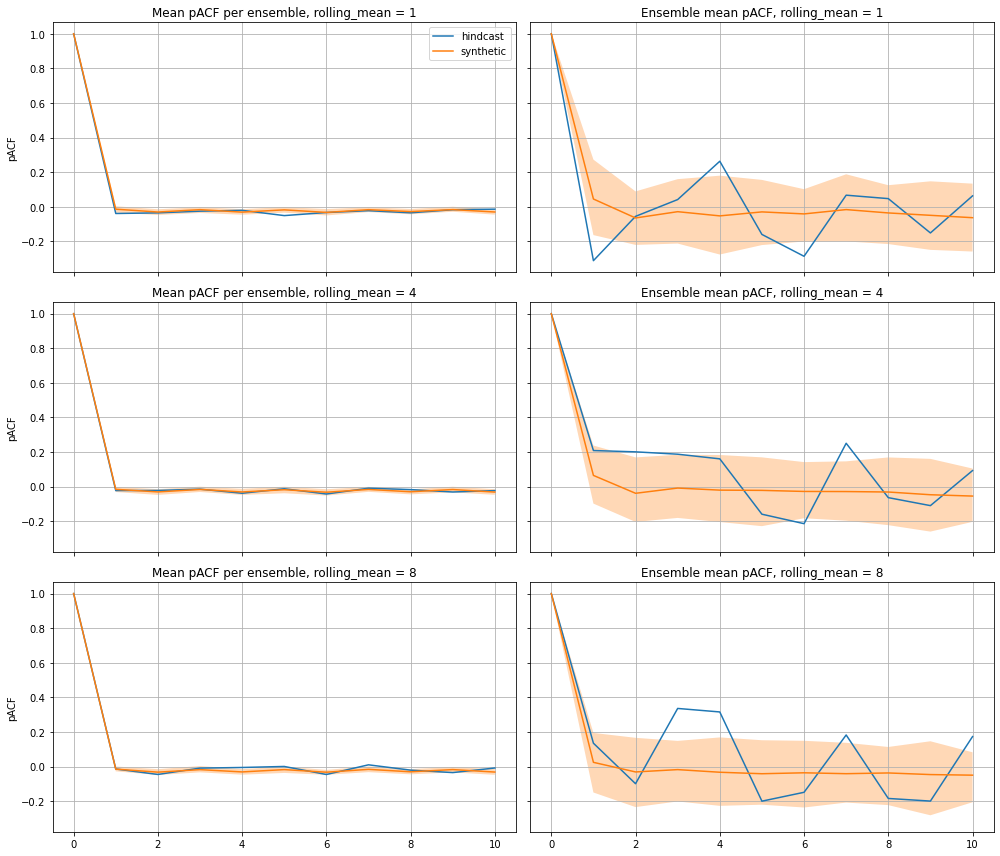

In [16]:
plot.acf(
    utils.detrend(hindcast_mean["NAO"]),
    utils.detrend(synthetic["NAO"]),
    headings=["hindcast", "synthetic"],
    partial=True,
    nlags=10,
)

#### How different are the parameters fitted to different datasets?

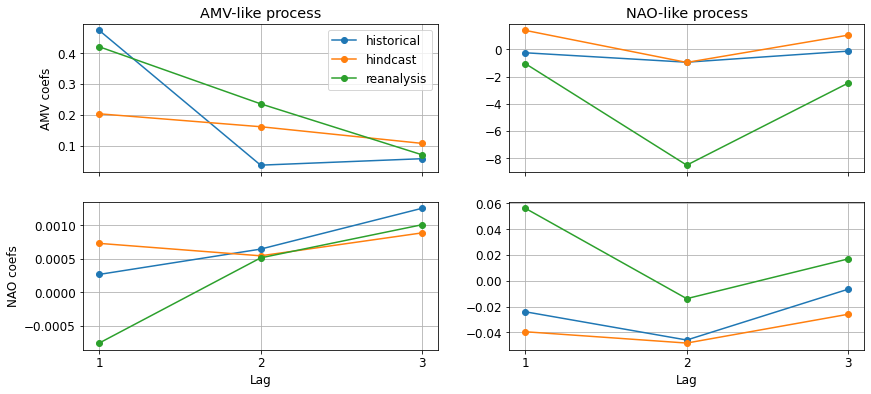

In [19]:
n_lags = 3

params = ar_model.fit(historical, n_lags=n_lags).mean("member")
fig = plot.params(params, label="historical")

params = ar_model.fit(
    hindcast_mean.sel(rolling_mean=1).dropna("time"), n_lags=n_lags
).mean("member")
plot.params(params, label="hindcast", fig=fig)

params = ar_model.fit(reanalysis, n_lags=n_lags)
_ = plot.params(params, label="reanalysis", fig=fig)

#### Start your synthetic forecasts from real initial conditions and compare to real hindcasts

In [20]:
n_lags = 3

params = ar_model.fit(historical, n_lags=n_lags).mean("member")

In [39]:
n_steps = 8

prediction = ar_model.predict(
    params, reanalysis, n_steps=n_steps, n_members=hindcast.sizes["member"]
)
prediction = prediction.sel(init=hindcast.init)

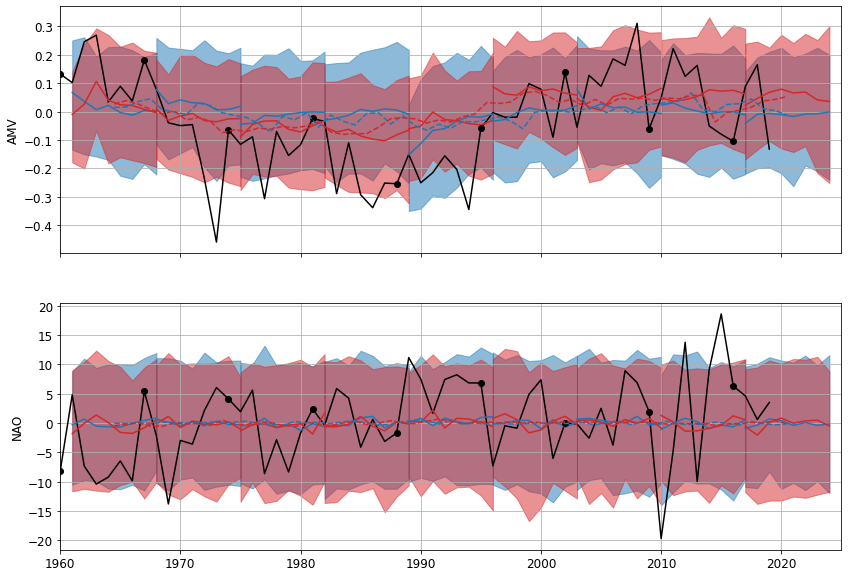

In [40]:
q = (0.05, 0.95)

fig = plt.figure(figsize=(14, 10))
axs = fig.subplots(len(hindcast), 1, sharex=True)

for idx, var in enumerate(hindcast):
    ax = axs[idx]
    ax.plot(reanalysis.time, reanalysis[var], color="k")
    for init in hindcast.init.values[:: n_steps - 1]:
        ax.plot(
            init,
            reanalysis[var].sel(time=init),
            marker="o",
            markersize=6,
            color="k",
        )

        prediction_plot = prediction[var].sel(init=init)
        ax.fill_between(
            prediction_plot.lead + init,
            prediction_plot.quantile(q[0], "member"),
            prediction_plot.quantile(q[1], "member"),
            alpha=0.5,
            color="C0",
        )
        ax.plot(prediction_plot.lead + init, prediction_plot.mean("member"), color="C0")

        hindcast_plot = hindcast[var].sel(init=init, lead=slice(n_steps))
        ax.fill_between(
            hindcast_plot.lead + init,
            hindcast_plot.quantile(q[0], "member"),
            hindcast_plot.quantile(q[1], "member"),
            alpha=0.5,
            color="C3",
        )
        ax.plot(hindcast_plot.lead + init, hindcast_plot.mean("member"), color="C3")

        ax.set_ylabel(var)

    ax.plot(
        prediction.lead.mean("lead") + prediction.init,
        prediction[var].mean(["lead", "member"]),
        color="C0",
        linestyle="--",
    )

    ax.plot(
        hindcast.lead.sel(lead=slice(n_steps)).mean("lead") + hindcast.init,
        hindcast[var].sel(lead=slice(n_steps)).mean(["lead", "member"]),
        color="C3",
        linestyle="--",
    )


_ = ax.set_xlim(hindcast.init.min(), hindcast.init.max() + 9)

In [41]:
n_steps = 8

prediction.sel(lead=slice(n_steps))

<xarray.Dataset>
Dimensions:  (init: 57, member: 125, lead: 8)
Coordinates:
  * member   (member) int64 0 1 2 3 4 5 6 7 ... 117 118 119 120 121 122 123 124
  * init     (init) int64 1960 1961 1962 1963 1964 ... 2012 2013 2014 2015 2016
  * lead     (lead) int64 1 2 3 4 5 6 7 8
Data variables:
    AMV      (init, member, lead) float32 0.2654 0.01633 ... 0.1476 0.1388
    NAO      (init, member, lead) float32 4.408 8.838 2.41 ... 8.475 8.6 1.452

In [42]:
hindcast.sel(lead=slice(n_steps))

<xarray.Dataset>
Dimensions:  (init: 57, lead: 8, member: 125)
Coordinates:
  * init     (init) int64 1960 1961 1962 1963 1964 ... 2012 2013 2014 2015 2016
  * lead     (lead) int64 1 2 3 4 5 6 7 8
  * member   (member) int64 1 2 3 4 5 6 7 8 ... 118 119 120 121 122 123 124 125
    time     (init, lead) int64 1962 1963 1964 1965 1966 ... 2022 2023 2024 2025
    model    (member) <U18 'CanESM5' 'CanESM5' 'CanESM5' ... 'NorCPM1' 'NorCPM1'
Data variables:
    AMV      (init, member, lead) float64 -0.04975 -0.1255 ... -0.1588 -0.1481
    NAO      (init, member, lead) float64 -12.51 6.162 -0.2441 ... -5.09 -2.284

In [43]:
prediction_acf = stats.acf(
    prediction.sel(lead=slice(n_steps)).mean(["member", "lead"]),
    dim="init",
    partial=True,
)

hindcast_acf = stats.acf(
    hindcast.sel(lead=slice(n_steps)).mean(["member", "lead"]), dim="init", partial=True
)

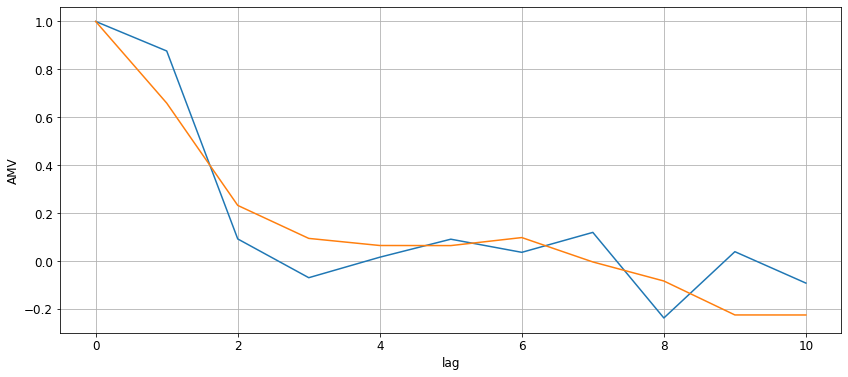

In [44]:
hindcast_acf["AMV"].plot()
prediction_acf["AMV"].plot()

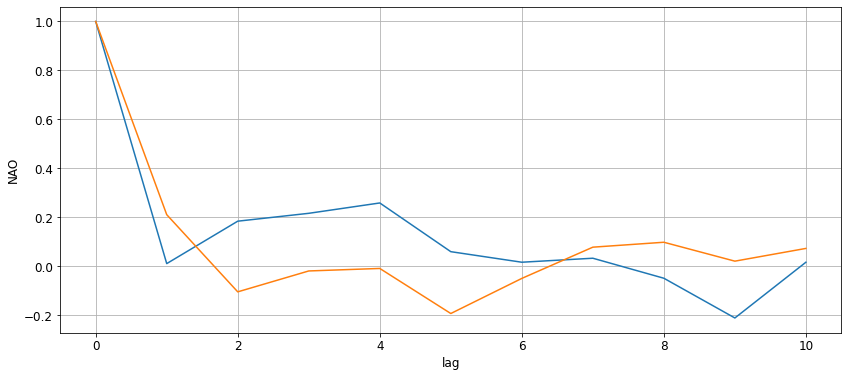

In [34]:
hindcast_acf["NAO"].plot()
prediction_acf["NAO"].plot()

#### What does a fit along lead give you?

In [65]:
params = ar_model.fit(hindcast, n_lags=2, dim="lead").mean(["init", "member"])

In [66]:
prediction = ar_model.predict(
    params, reanalysis, n_steps=9, n_members=hindcast.sizes["member"]
)
prediction = prediction.assign_coords({"init": prediction.init.dt.year})

(1960.0, 2027.0)

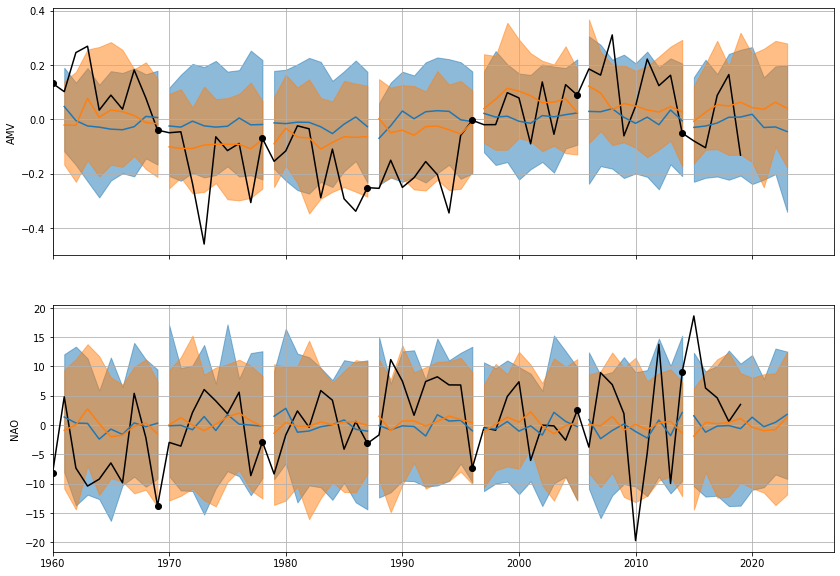

In [67]:
q = (0.05, 0.95)

fig = plt.figure(figsize=(14, 10))
axs = fig.subplots(len(hindcast), 1, sharex=True)

reanalysis_plot = reanalysis.assign_coords({"time": reanalysis.time.dt.year})
for idx, var in enumerate(hindcast):
    ax = axs[idx]
    ax.plot(reanalysis_plot.time, reanalysis[var], color="k")
    for init in hindcast.init.values[::9]:
        ax.plot(
            init,
            reanalysis_plot[var].sel(time=init),
            marker="o",
            markersize=6,
            color="k",
        )

        prediction_plot = prediction[var].sel(init=init)
        ax.fill_between(
            prediction_plot.lead + init,
            prediction_plot.quantile(q[0], "member"),
            prediction_plot.quantile(q[1], "member"),
            alpha=0.5,
            color="C0",
        )
        ax.plot(prediction_plot.lead + init, prediction_plot.mean("member"), color="C0")

        hindcast_plot = hindcast[var].sel(init=init)
        ax.fill_between(
            hindcast_plot.lead + init,
            hindcast_plot.quantile(q[0], "member"),
            hindcast_plot.quantile(q[1], "member"),
            alpha=0.5,
            color="C1",
        )
        ax.plot(hindcast_plot.lead + init, hindcast_plot.mean("member"), color="C1")

        ax.set_ylabel(var)

ax.set_xlim(hindcast.init.min(), hindcast.init.max() + 9)

## Boreal winter (December to March) NAO indices

In [ ]:
models = [

In [5]:
HadGEM3 = (
    xr.open_zarr(f"{DATA_DIR}/psl_Amon_HadGEM3-GC31-MM_dcpp.zarr", use_cftime=True)
    / 100
)
NAO_HadGEM3 = utils.calculate_period_NAO_index(
    HadGEM3["psl"],
    [12, 1, 2, 3],
).compute()
NAO_HadGEM3 = NAO_HadGEM3.isel(lead=slice(1, None))  # Drop first lead

In [6]:
ECEarth3 = (
    xr.open_zarr(f"{DATA_DIR}/psl_Amon_EC-Earth3_dcpp.zarr", use_cftime=True) / 100
)
NAO_ECEarth3 = utils.calculate_period_NAO_index(
    ECEarth3["psl"],
    [12, 1, 2, 3],
).compute()
NAO_ECEarth3 = NAO_ECEarth3.isel(lead=slice(1, None))  # Drop first lead

In [7]:
HadSLP = xr.open_zarr(f"{DATA_DIR}/psl_HadSLP2r.zarr", use_cftime=True)
NAO_HadSLP = utils.calculate_period_NAO_index(
    HadSLP["slp"],
    [12, 1, 2, 3],
).compute()

### Fit an AR model

In [195]:
input_data = NAO_HadSLP

res = ar_model.fit(
    input_data,
    order="select_order",
)
params = res[:-1].values
scale = res[-1].values

### Generate some synthetic forecasts

In [ ]:
inits = ar_model.generate_samples(
    params=params,
    scale=scale,
    n_times=NAO_HadGEM3.sizes["init"],
    n_samples=1,
)

In [10]:
NAO_synthetic = ar_model.predict(
    params=params,
    inits=inits,
    n_steps=NAO_HadGEM3.sizes["lead"],
    n_members=NAO_HadGEM3.sizes["member"],
    scale=scale,
)

NAO_synthetic = NAO_synthetic.assign_coords(
    {"time": NAO_synthetic.init + NAO_synthetic.lead}
)

### How do the synthetic forecasts compare to the real forecasts?

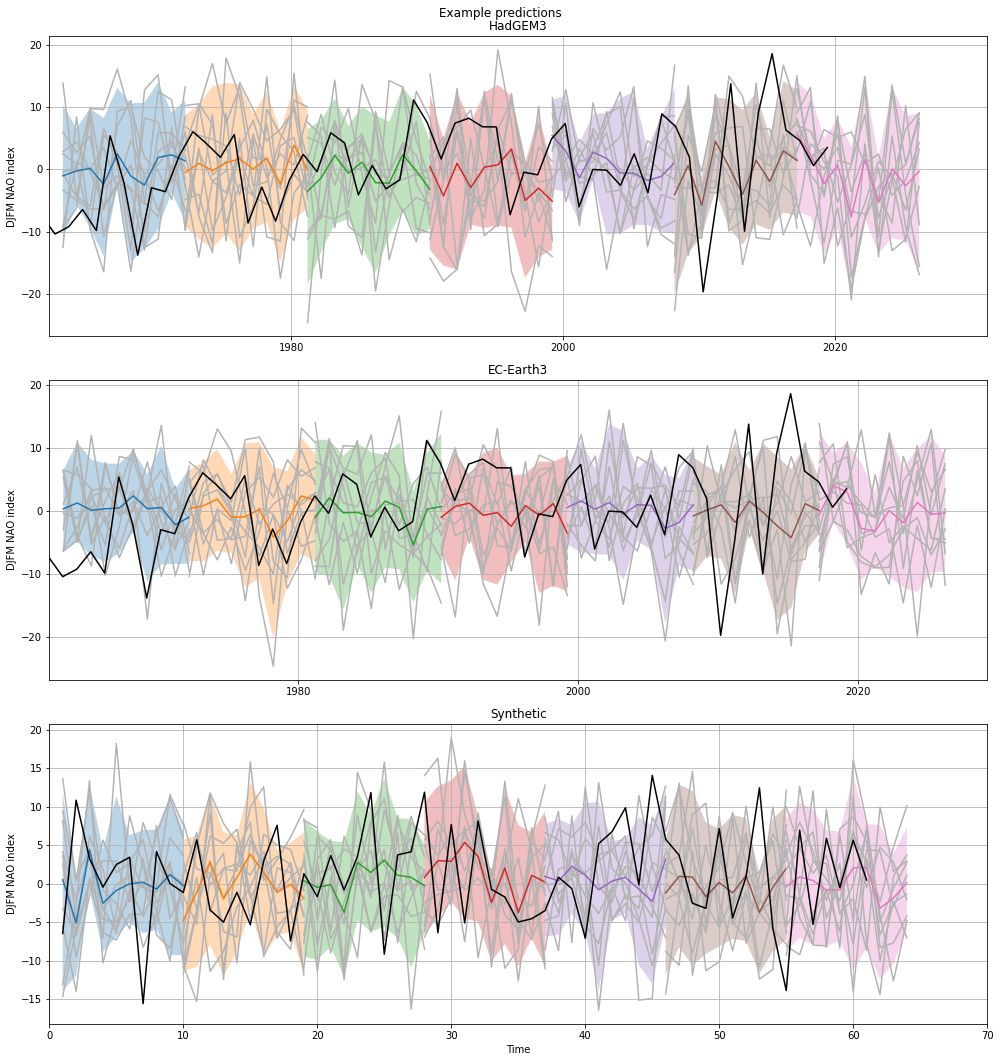

In [11]:
to_plot = {
    "HadGEM3": (NAO_HadGEM3, NAO_HadSLP),
    "EC-Earth3": (NAO_ECEarth3, NAO_HadSLP),
    "Synthetic": (NAO_synthetic, inits),
}

nrows = len(to_plot)
fig = plt.figure(figsize=(14, 5 * nrows))
axs = fig.subplots(nrows, 1)

for i, (name, (fcst, init)) in enumerate(to_plot.items()):
    ax = axs[i]

    for i in fcst.init[1::9]:
        fcst_plot = fcst.sel(init=i)
        ax.fill_between(
            fcst_plot.time.values,
            fcst_plot.quantile(0.05, dim="member"),
            fcst_plot.quantile(0.95, dim="member"),
            edgecolor="none",
            alpha=0.3,
        )
        for m in fcst_plot.member:
            ax.plot(
                fcst_plot.time.values, fcst_plot.sel(member=m), color=[0.7, 0.7, 0.7]
            )
        ax.plot(
            fcst_plot.time.values,
            fcst_plot.mean("member"),
        )
        ax.set_title(name)
    ax.set_xlim(fcst.time.min().item(), fcst.time.max().item())
    ax.set_ylabel("DJFM NAO index")

    ax.plot(init.time, init, color="k")

ax.set_xlabel("Time")
fig.suptitle("Example predictions")
fig.tight_layout()

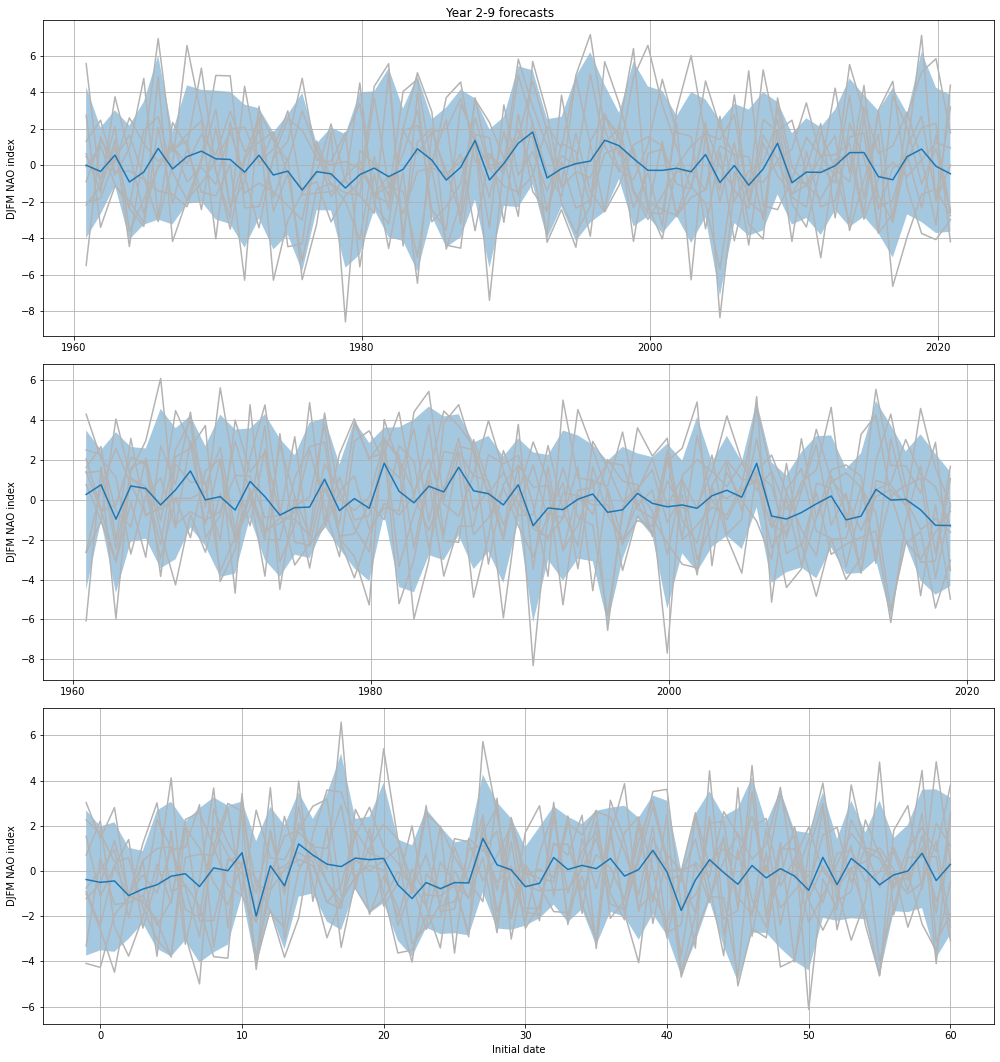

In [12]:
avg = (0, 8)

to_plot = {
    "HadGEM3": NAO_HadGEM3.isel(lead=slice(*avg)).mean("lead"),
    "EC-Earth3": NAO_ECEarth3.isel(lead=slice(*avg)).mean("lead"),
    "Synthetic": NAO_synthetic.isel(lead=slice(*avg)).mean("lead"),
}

nrows = len(to_plot)
fig = plt.figure(figsize=(14, 5 * nrows))
axs = fig.subplots(nrows, 1)

for i, (name, fcst) in enumerate(to_plot.items()):
    ax = axs[i]

    ax.fill_between(
        fcst.init.values,
        fcst.quantile(0.05, dim="member"),
        fcst.quantile(0.95, dim="member"),
        edgecolor="none",
        alpha=0.4,
    )
    for m in fcst.member:
        ax.plot(fcst.init.values, fcst.sel(member=m), color=[0.7, 0.7, 0.7])
    ax.plot(
        fcst.init.values,
        fcst.mean("member"),
    )
    ax.set_title("")  # name)
    ax.set_ylabel("DJFM NAO index")

ax.set_xlabel("Initial date")
fig.suptitle("Year 2-9 forecasts")
fig.tight_layout()

## Boreal winter (December to March) AMV indices

In [13]:
HadGEM3["tos"] = xr.open_zarr(
    f"{DATA_DIR}/tos_Omon_HadGEM3-GC31-MM_dcpp.zarr", use_cftime=True
)["tos"]
AMV_HadGEM3 = utils.calculate_period_AMV_index(
    HadGEM3["tos"],
    [12, 1, 2, 3],
).compute()
AMV_HadGEM3 = AMV_HadGEM3.isel(lead=slice(1, None))  # Drop first lead

In [14]:
ECEarth3["tos"] = xr.open_zarr(
    f"{DATA_DIR}/tos_Omon_EC-Earth3_dcpp.zarr", use_cftime=True
)["tos"]
AMV_ECEarth3 = utils.calculate_period_AMV_index(
    ECEarth3["tos"],
    [12, 1, 2, 3],
).compute()
AMV_ECEarth3 = AMV_ECEarth3.isel(lead=slice(1, None))  # Drop first lead

In [15]:
HadISST = xr.open_zarr(f"{DATA_DIR}/tos_HadISST.zarr", use_cftime=True)
AMV_HadISST = utils.calculate_period_AMV_index(
    HadISST["sst"],
    [12, 1, 2, 3],
).compute()

### Fit an AR model

In [16]:
input_data = AMV_HadISST

res = ar_model.fit(
    input_data,
    order="select_order",
    select_order_kwargs={"maxlag": 10, "ic": "aic", "glob": False, "trend": "n"},
)
params = res[:-1].values
scale = res[-1].values

### Generate some synthetic forecasts

In [22]:
inits = ar_model.generate_samples(
    params=params,
    scale=scale,
    n_times=AMV_HadGEM3.sizes["init"],
    n_samples=1,
)

In [23]:
AMV_synthetic = ar_model.predict(
    params=params,
    inits=inits,
    n_steps=AMV_HadGEM3.sizes["lead"],
    n_members=AMV_HadGEM3.sizes["member"],
    scale=scale,
)

AMV_synthetic = AMV_synthetic.assign_coords(
    {"time": AMV_synthetic.init + AMV_synthetic.lead}
)

### How do the synthetic forecasts compare to the real forecasts?

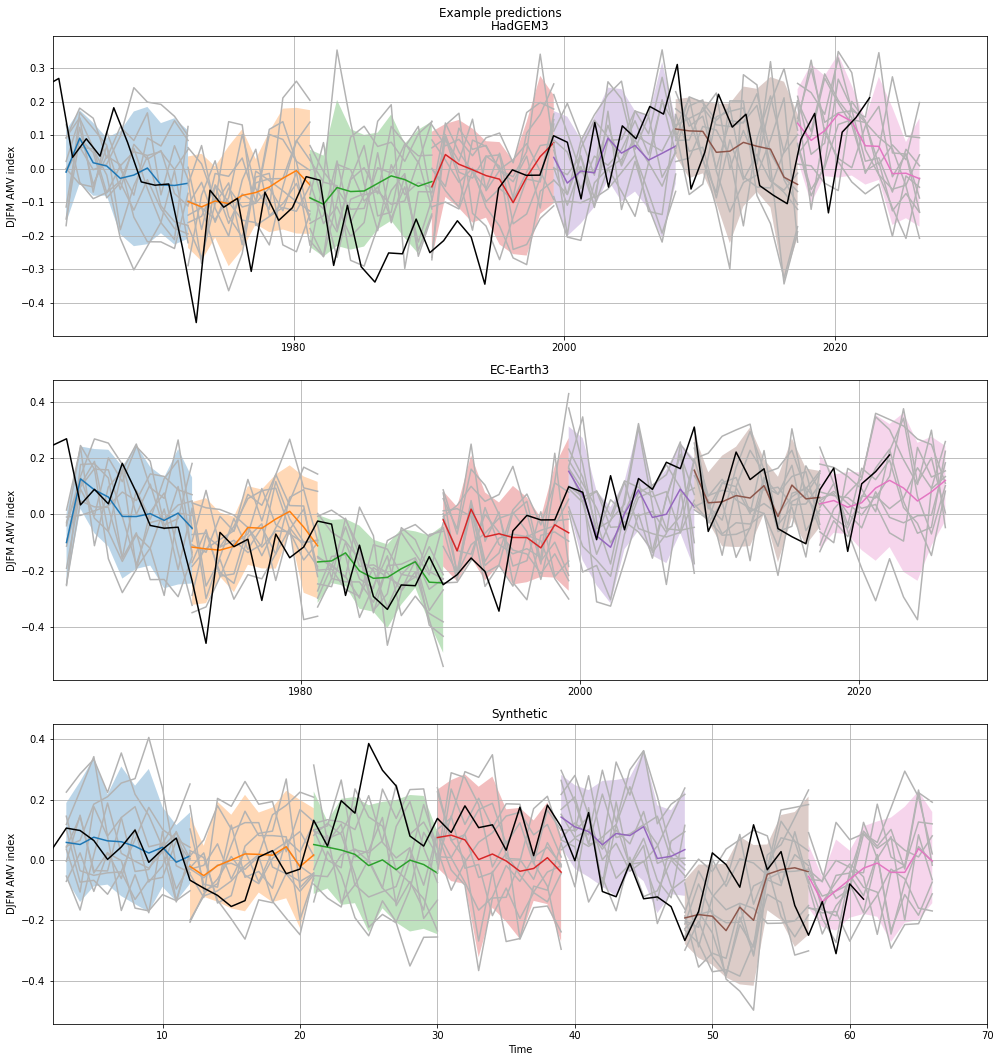

In [24]:
to_plot = {
    "HadGEM3": (AMV_HadGEM3, AMV_HadISST),
    "EC-Earth3": (AMV_ECEarth3, AMV_HadISST),
    "Synthetic": (AMV_synthetic, inits),
}

nrows = len(to_plot)
fig = plt.figure(figsize=(14, 5 * nrows))
axs = fig.subplots(nrows, 1)

for i, (name, (fcst, init)) in enumerate(to_plot.items()):
    ax = axs[i]

    for i in fcst.init[1::9]:
        fcst_plot = fcst.sel(init=i)
        ax.fill_between(
            fcst_plot.time.values,
            fcst_plot.quantile(0.05, dim="member"),
            fcst_plot.quantile(0.95, dim="member"),
            edgecolor="none",
            alpha=0.3,
        )
        for m in fcst_plot.member:
            ax.plot(
                fcst_plot.time.values, fcst_plot.sel(member=m), color=[0.7, 0.7, 0.7]
            )
        ax.plot(
            fcst_plot.time.values,
            fcst_plot.mean("member"),
        )
        ax.set_title(name)
    ax.set_xlim(fcst.time.min().item(), fcst.time.max().item())
    ax.set_ylabel("DJFM AMV index")

    ax.plot(init.time, init, color="k")

ax.set_xlabel("Time")
fig.suptitle("Example predictions")
fig.tight_layout()

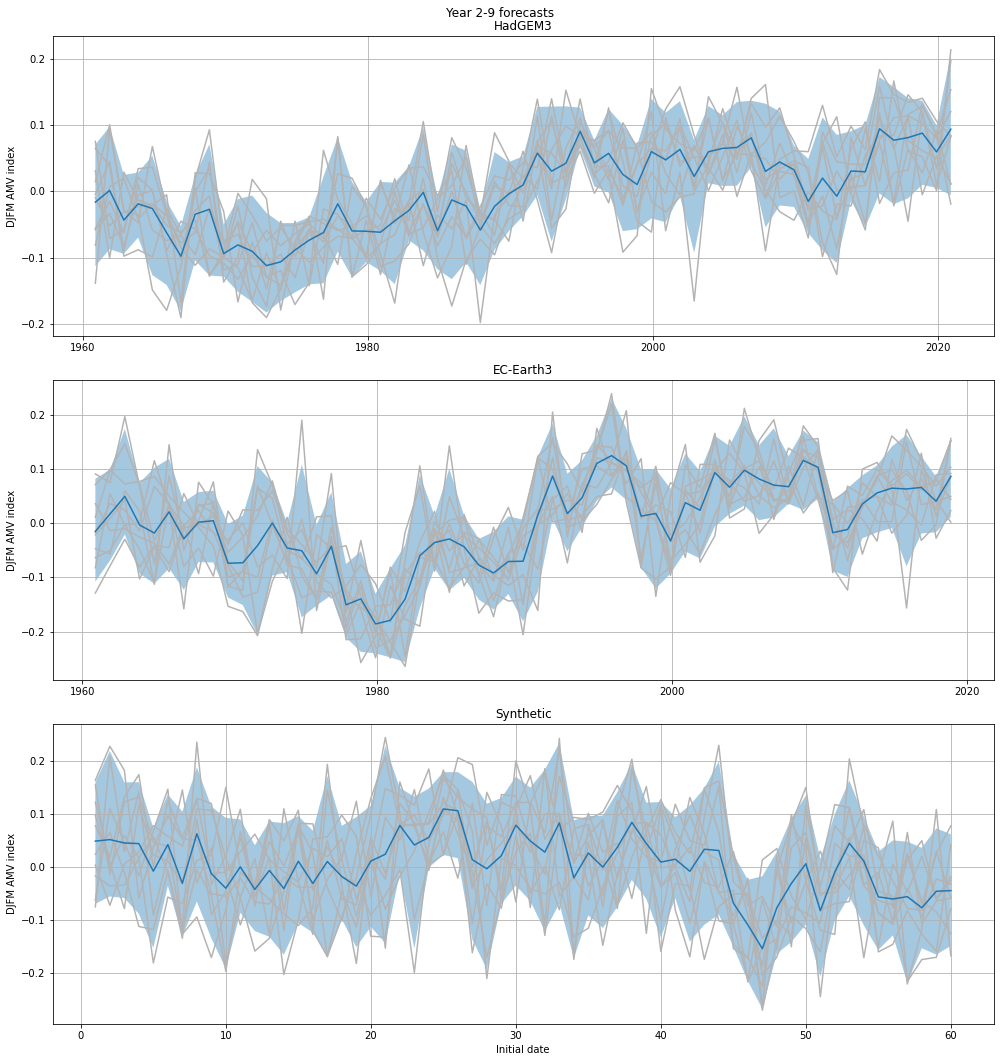

In [25]:
avg = (0, 8)

to_plot = {
    "HadGEM3": AMV_HadGEM3.isel(lead=slice(*avg)).mean("lead"),
    "EC-Earth3": AMV_ECEarth3.isel(lead=slice(*avg)).mean("lead"),
    "Synthetic": AMV_synthetic.isel(lead=slice(*avg)).mean("lead"),
}

nrows = len(to_plot)
fig = plt.figure(figsize=(14, 5 * nrows))
axs = fig.subplots(nrows, 1)

for i, (name, fcst) in enumerate(to_plot.items()):
    ax = axs[i]

    ax.fill_between(
        fcst.init.values,
        fcst.quantile(0.05, dim="member"),
        fcst.quantile(0.95, dim="member"),
        edgecolor="none",
        alpha=0.4,
    )
    for m in fcst.member:
        ax.plot(fcst.init.values, fcst.sel(member=m), color=[0.7, 0.7, 0.7])
    ax.plot(
        fcst.init.values,
        fcst.mean("member"),
    )
    ax.set_title(name)
    ax.set_ylabel("DJFM AMV index")

ax.set_xlabel("Initial date")
fig.suptitle("Year 2-9 forecasts")
fig.tight_layout()